In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from utils import *
from models.diffusion import *
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.ndimage import rotate
from itertools import chain
from torchvision import transforms
from torchvision.utils import save_image

from IPython.display import HTML
from IPython.display import clear_output

/home/oem/anaconda3/envs/xu/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# initialize random seed
SEED = 0
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)

# cuda = True if torch.cuda.is_available() else False
# FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
# torch.set_default_tensor_type(FloatTensor)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sample_dir = './results/MNIST_DDPM'
model_dir = './results/checkpoints/DDPM_MNIST'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

if not os.path.exists(model_dir):
    os.makedirs(model_dir)

In [3]:
joint_training = True
load_available = True
image_size = 784
h_dim = 400
z_dim = 20
num_epochs = 100
batch_size = 128
learning_rate = 1e-3

eps = 1e-6
sigma_min = 0.001
sigma_max = 10
n_steps = 10
annealed_step = 100

num_steps = 100

#制定每一步的beta
betas = torch.linspace(-6,6,num_steps)
betas = torch.sigmoid(betas)*(0.5e-2 - 1e-5)+1e-5

#计算alpha、alpha_prod、alpha_prod_previous、alpha_bar_sqrt等变量的值
alphas = 1-betas
alphas_prod = torch.cumprod(alphas,0)
alphas_prod_p = torch.cat([torch.tensor([1]).float(),alphas_prod[:-1]],0)
alphas_bar_sqrt = torch.sqrt(alphas_prod)
one_minus_alphas_bar_log = torch.log(1 - alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)

assert alphas.shape==alphas_prod.shape==alphas_prod_p.shape==\
alphas_bar_sqrt.shape==one_minus_alphas_bar_log.shape\
==one_minus_alphas_bar_sqrt.shape
print("all the same shape",betas.shape)

all the same shape torch.Size([100])


In [19]:
alphas_bar_sqrt[40]

tensor(0.9939)

In [4]:
# MNIST dataset
dataset = torchvision.datasets.MNIST(root='../../Data/MNIST/',
                                     train=True,
                                     transform=transforms.ToTensor(),
                                     download=True)

# Data loader
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

In [5]:
vae = VAE(input_size=image_size, h_dim=h_dim, z_dim=z_dim, type='ce').to(device)
vae_optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate)

# sn = SN_Model(device, n_steps, sigma_min, sigma_max, dim=z_dim, p = 0.3)
sn = MLPDiffusion(num_steps)
sn_optim = torch.optim.Adam(sn.parameters(), lr = 1e-3)
joint_optim = torch.optim.Adam(params=chain(vae.parameters(), sn.parameters()))

In [6]:
# Start training
for epoch in range(num_epochs):
    for i, (x, _) in enumerate(data_loader):
        x = x.to(device).view(-1, image_size)
        if joint_training:
            mu, log_var = vae.encode(x)
            z = vae.reparameterize(mu, log_var)
            x_reconst = vae.decode(z)
            # Compute reconstruction loss and kl divergence
            reconst_loss = F.binary_cross_entropy(x_reconst, x, size_average=False)
            kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            loss_sn = diffusion_loss_fn(sn, z,alphas_bar_sqrt,one_minus_alphas_bar_sqrt,num_steps)
            loss = loss_sn + reconst_loss + kl_div

            joint_optim.zero_grad()
            loss.backward()
            joint_optim.step()
        else:
            #============= First Stage: Update VAE ==============#
            # Forward pass
            x_reconst, mu, log_var = vae(x)
            # Compute reconstruction loss and kl divergence
            # For KL divergence, see Appendix B in VAE paper or http://yunjey47.tistory.com/43
            reconst_loss = F.binary_cross_entropy(x_reconst, x, size_average=False)
            kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            
            # Backprop and optimize
            vae_loss = reconst_loss + kl_div
            vae_optimizer.zero_grad()
            vae_loss.backward()
            vae_optimizer.step()

            #============= Second Stage: Update SN ==============#
            mu, log_var = vae.encode(x)
            z = vae.reparameterize(mu, log_var)

            loss_sn = sn.loss(z)
            vae_optimizer.zero_grad()
            sn_optim.zero_grad()
            loss_sn.backward()
            sn_optim.step()

        if (i+1) % 100 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}, Diffuse loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item(), kl_div.item(), loss_sn.item()))

    with torch.no_grad():
        # Save the sampled images
        z = torch.randn(x.shape[0], z_dim).to(device)
        out = vae.decode(z).view(-1, 1, 28, 28)
        x_concat = torch.cat([x.view(-1, 1, 28, 28), out], dim=3)
        save_image(x_concat, os.path.join(sample_dir, 'sampled-{}.png'.format(epoch+1)))

        # Save the reconstructed images
        out, _, _ = vae(x)
        x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)
        save_image(x_concat, os.path.join(sample_dir, 'reconst-{}.png'.format(epoch+1)))

        # Save the diffused ima ges
        # dynamic = AnnealedLangevinDynamic(sigma_min, sigma_max, n_steps, annealed_step, sn, device, eps=eps)
        # z_ = forward_proc(z, sigma_min, sigma_max, n_steps, device=device, only_final=True)
        # sample = dynamic.sampling(x.shape[0], z_dim, sample=z_, only_final=True)

        sample = ddim_sample(sn, num_steps=num_steps, batch_size=x.shape[0], dim=z_dim)
        # sample = dynamic.sampling(x.shape[0], z_dim, only_final=True)
        out = vae.decode(sample).view(-1, 1, 28, 28)
        x_concat = torch.cat([x.view(-1, 1, 28, 28), out], dim=3)
        save_image(x_concat, os.path.join(sample_dir, 'diffuse-{}.png'.format(epoch+1)))
torch.save({'sn_state':sn.state_dict(), 'vae_state':vae.state_dict()}, model_dir+'ckpt.pth')

/home/oem/anaconda3/envs/xu/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch[1/100], Step [100/469], Reconst Loss: 21895.4082, KL Div: 1386.0198, Diffuse loss: 0.9691
Epoch[1/100], Step [200/469], Reconst Loss: 17678.4805, KL Div: 1897.8455, Diffuse loss: 1.0043
Epoch[1/100], Step [300/469], Reconst Loss: 16089.0830, KL Div: 2026.5127, Diffuse loss: 0.9869
Epoch[1/100], Step [400/469], Reconst Loss: 15024.9023, KL Div: 2522.7236, Diffuse loss: 1.0276
Epoch[2/100], Step [100/469], Reconst Loss: 13054.2422, KL Div: 2634.9219, Diffuse loss: 0.9988
Epoch[2/100], Step [200/469], Reconst Loss: 13052.2402, KL Div: 2696.2197, Diffuse loss: 0.9633
Epoch[2/100], Step [300/469], Reconst Loss: 12359.7207, KL Div: 2880.6323, Diffuse loss: 0.9779
Epoch[2/100], Step [400/469], Reconst Loss: 12272.3213, KL Div: 2987.8767, Diffuse loss: 0.9717
Epoch[3/100], Step [100/469], Reconst Loss: 12133.9316, KL Div: 2897.1218, Diffuse loss: 0.9678
Epoch[3/100], Step [200/469], Reconst Loss: 11136.5479, KL Div: 2979.1045, Diffuse loss: 0.9626
Epoch[3/100], Step [300/469], Reconst Lo

### Generate samples

In [9]:
import math

def ani_imshow(sample, sampling_number = 64):

    row_number = int(math.sqrt(sampling_number))
    col_number = int(math.sqrt(sampling_number))
    sample = sample[:sampling_number].detach().cpu().numpy()
    shape = sample.shape
    show_sample = np.zeros([row_number * shape[2], col_number * shape[3] ]).astype(np.float32)
    for row in range(row_number):
        for col in range(col_number):
            sample_ = sample[row + col * row_number][0]
            show_sample[ row * shape[2] : (row+1) * shape[2], col * shape[3] : (col+1) * shape[3] ] = (sample_ - sample_.min()) / (sample_.max() - sample_.min()) * 255

    show_sample = show_sample.astype(np.uint8)

    return show_sample

(-0.5, 251.5, 251.5, -0.5)

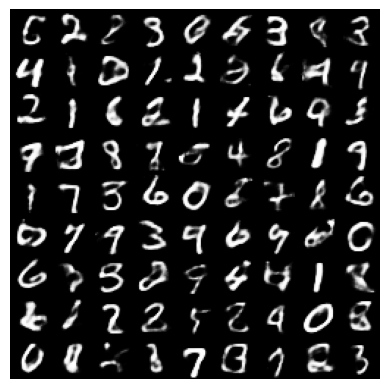

In [13]:
sample = ddim_sample(sn, num_steps=num_steps, batch_size=x.shape[0], dim=z_dim)
# sample = dynamic.sampling(x.shape[0], z_dim, only_final=True)
data_sample = vae.decode(sample).view(-1, 1, 28, 28)

plt.imshow(ani_imshow(data_sample, sampling_number = sample.shape[0]), animated=True, cmap = 'gray')
plt.axis('off')

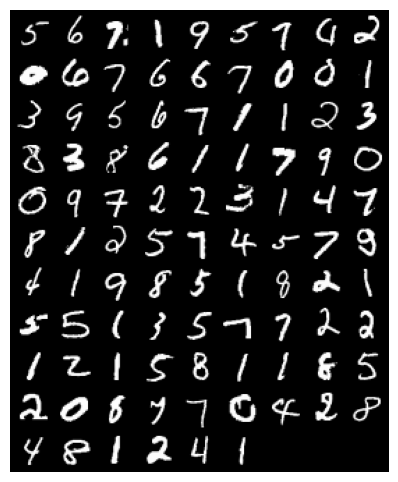

In [14]:
# original data
from torchvision.utils import make_grid

sample_grid = make_grid(x.view(-1, 1, 28, 28), nrow=int(np.sqrt(x.shape[0])))

select_t = 0.3

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

In [29]:
# forward process
mu, log_var = vae.encode(x.view(-1, image_size))
z = vae.reparameterize(mu, log_var)

In [30]:
z_ = alphas_bar_sqrt[-1]*z + one_minus_alphas_bar_sqrt[-1]*torch.randn_like(z)

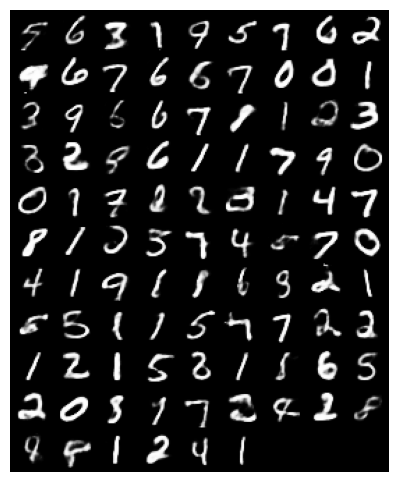

In [31]:
sample = ddim_sample(sn, num_steps=num_steps, dim=z_dim, x_T=z_)
# sample = dynamic.sampling(x.shape[0], z_dim, only_final=True)
data_sample = vae.decode(sample).view(-1, 1, 28, 28)

sample_grid = make_grid(data_sample, nrow=int(np.sqrt(data_sample.shape[0])))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()